## Content Outline

### Other Methods
* Recursive feature addition
* Recursive feature elimination
* Selection by feature shuffling

### 8.1 Recursive feature addition

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.base import clone
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# feature engine
from feature_engine.selection import RecursiveFeatureAddition


In [3]:
brest_cancer = load_breast_cancer()
X = pd.DataFrame(brest_cancer.data, columns = brest_cancer.feature_names)
y = brest_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [4]:
model = GradientBoostingClassifier(
    n_estimators=5,
    random_state=10
)

rfa = RecursiveFeatureAddition(
    estimator=model,
    scoring="roc_auc",
    threshold = 0.0001,
    cv = 2
    )

rfa.fit(X_train, y_train)
rfa.initial_model_performance_

0.9676361015186747

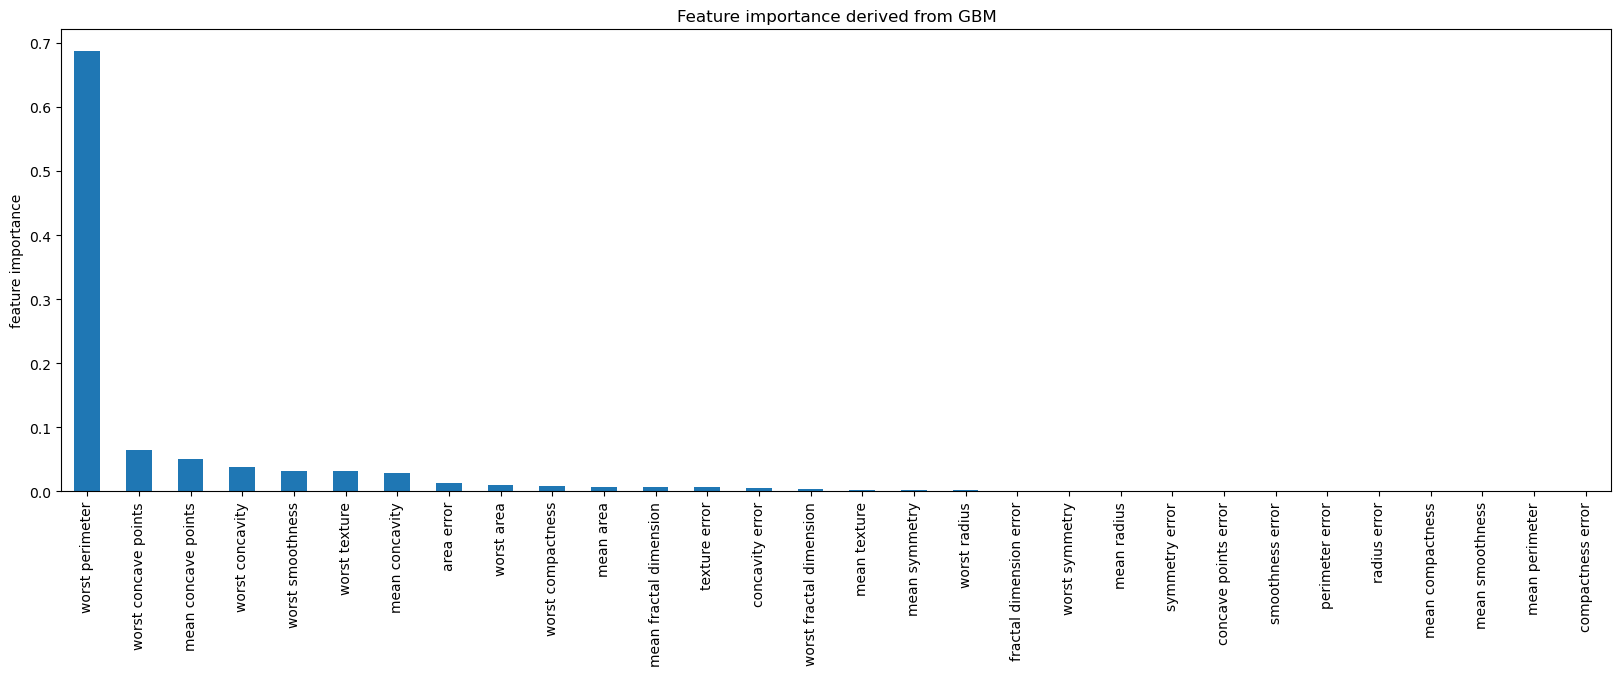

In [6]:
# Plot feature importance
rfa.feature_importances_.plot.bar(figsize = (20, 6))
plt.ylabel("feature importance")
plt.title("Feature importance derived from GBM")
plt.show()

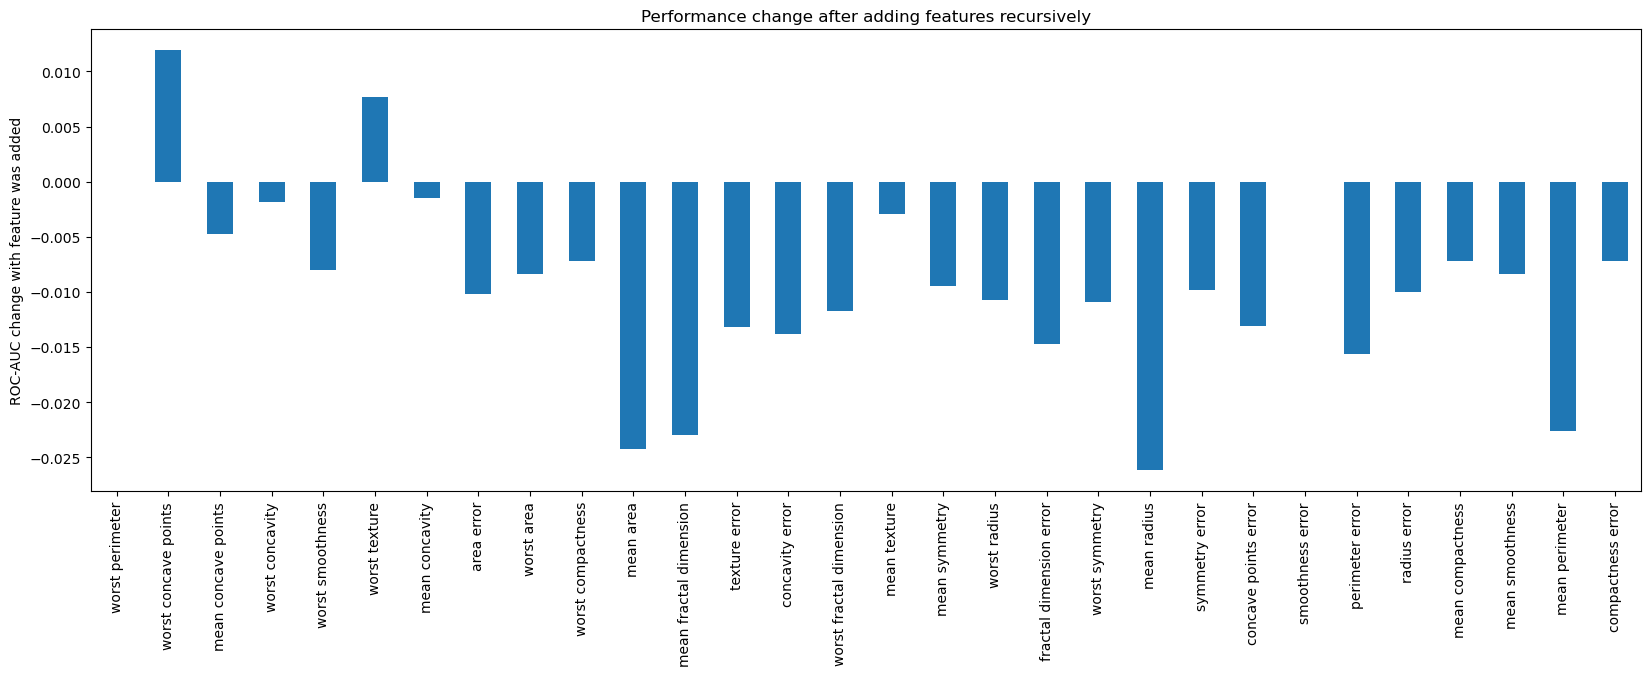

In [7]:
### Plot change in performance

pd.Series(rfa.performance_drifts_).plot.bar(figsize = (20, 6))
plt.ylabel("ROC-AUC change with feature was added")
plt.title("Performance change after adding features recursively")
plt.show()

In [8]:
# Features to drop
rfa.features_to_drop_

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst symmetry',
 'worst fractal dimension']

In [9]:
X_train_t = rfa.transform(X_train)
X_test_t = rfa.transform(X_test)

X_test_t.head()

,worst texture,worst perimeter,worst concave points
512,29.66,113.30,0.20510
457,34.23,91.29,0.06005
439,19.31,96.53,0.08216
298,25.26,105.80,0.07530
37,22.81,84.46,0.05013


##### Step by step feature addition implementation

In [28]:
model.fit(X_train , y_train)

y_pred_test = model.predict_proba(X_test)[:, 1]
y_pred_test[0:10]

array([0.37364718, 0.77013317, 0.77013317, 0.77013317, 0.77013317,
       0.77013317, 0.77013317, 0.77013317, 0.77013317, 0.77013317])

In [29]:
roc_full = roc_auc_score(y_test, y_pred_test)
print(f'ROC AUC full dataset = {roc_full}')

ROC AUC full dataset = 0.9731656184486374


In [30]:
### Sort the features based on their importance in decreasing order

features = pd.Series(model.feature_importances_, 
                     index = X_train.columns).sort_values(ascending = False)
features.head()

mean concave points    0.754473
worst area             0.049151
worst radius           0.044597
worst texture          0.035570
worst perimeter        0.029786
dtype: float64

In [31]:
# Train the model with most important feature and store the performance
features = list(features.index)

model_one_feature = clone(model)
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]
roc_first = roc_auc_score(y_test, y_pred_test)
print(f'ROC AUC one fature = {roc_first}')

ROC AUC one fature = 0.9548218029350105


In [33]:
tot = 0.0001

features_to_keep = [features[0]]

for feature in features[1:]:
    
    # initial model
    model_int = clone(model)
    
    # fit and predict
    model_int.fit(X_train[features_to_keep + [feature]], y_train)
    y_pred_test = model_int.predict_proba(X_test[features_to_keep + [feature]])[:, 1]
    
    # Model evaluation
    roc_int = roc_auc_score(y_test, y_pred_test)
    
    # roc_auc comparision
    diff_roc = roc_int - roc_first
    
    if diff_roc >= tot:
        roc_first = roc_int
        
        features_to_keep.append(feature)
    
print(f'number of features to keep: {len(features_to_keep)}')
    

number of features to keep: 5


In [34]:
### Final model perfromance check

model_final = clone(model)

model_final.fit(X_train[features_to_keep], y_train)
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:,1]
roc_final = roc_auc_score(y_test, y_pred_test)
print(f'ROC AUC one fature = {roc_final}')

ROC AUC one fature = 0.9926624737945493


### 8.2 Recursive Feature Elemination

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.base import clone
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# feature engine
from feature_engine.selection import RecursiveFeatureElimination


In [37]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

model = GradientBoostingRegressor(
    n_estimators=5,
    random_state = 10
)

sel = RecursiveFeatureElimination(
    estimator=model,
    scoring = "r2",
    threshold = 0.001,
    cv = 2
)

sel.fit(X_train, y_train)
sel.initial_model_performance_

0.3639885983830904

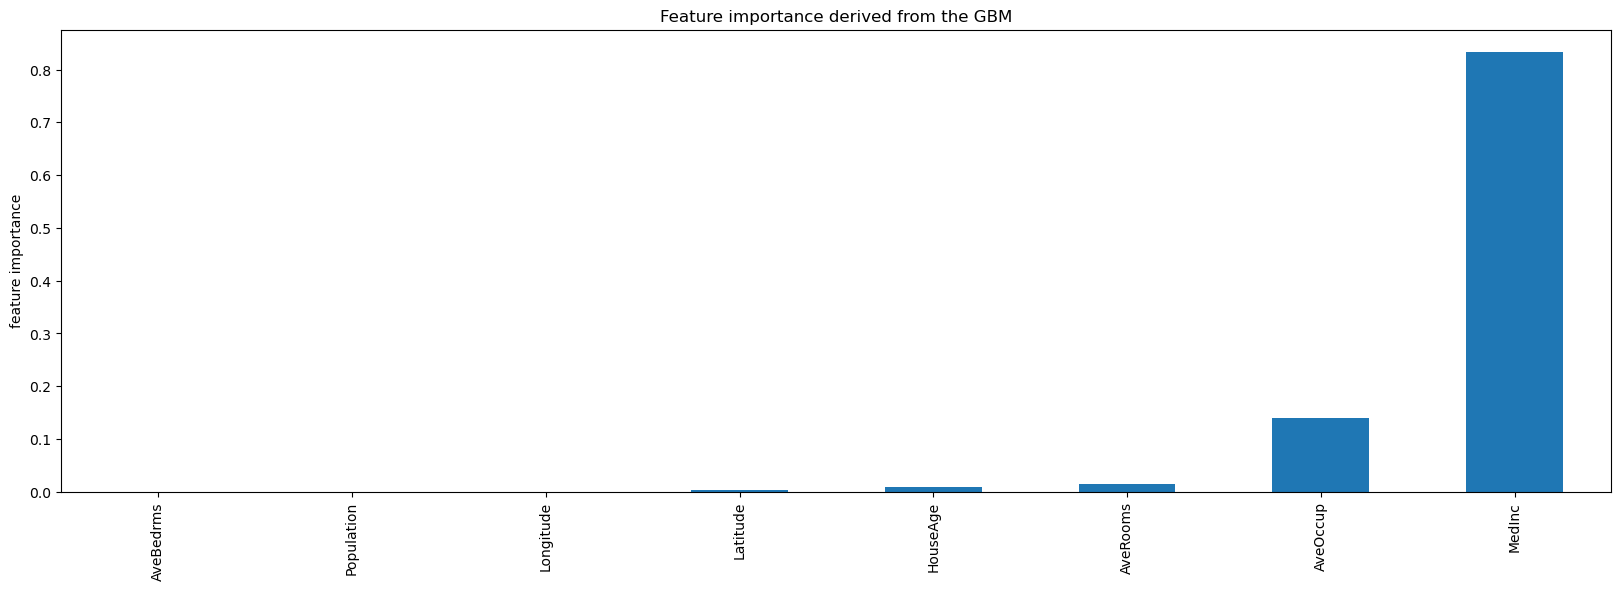

In [38]:
sel.feature_importances_.plot.bar(figsize = (20, 6))
plt.ylabel("feature importance")
plt.title("Feature importance derived from the GBM")
plt.show()

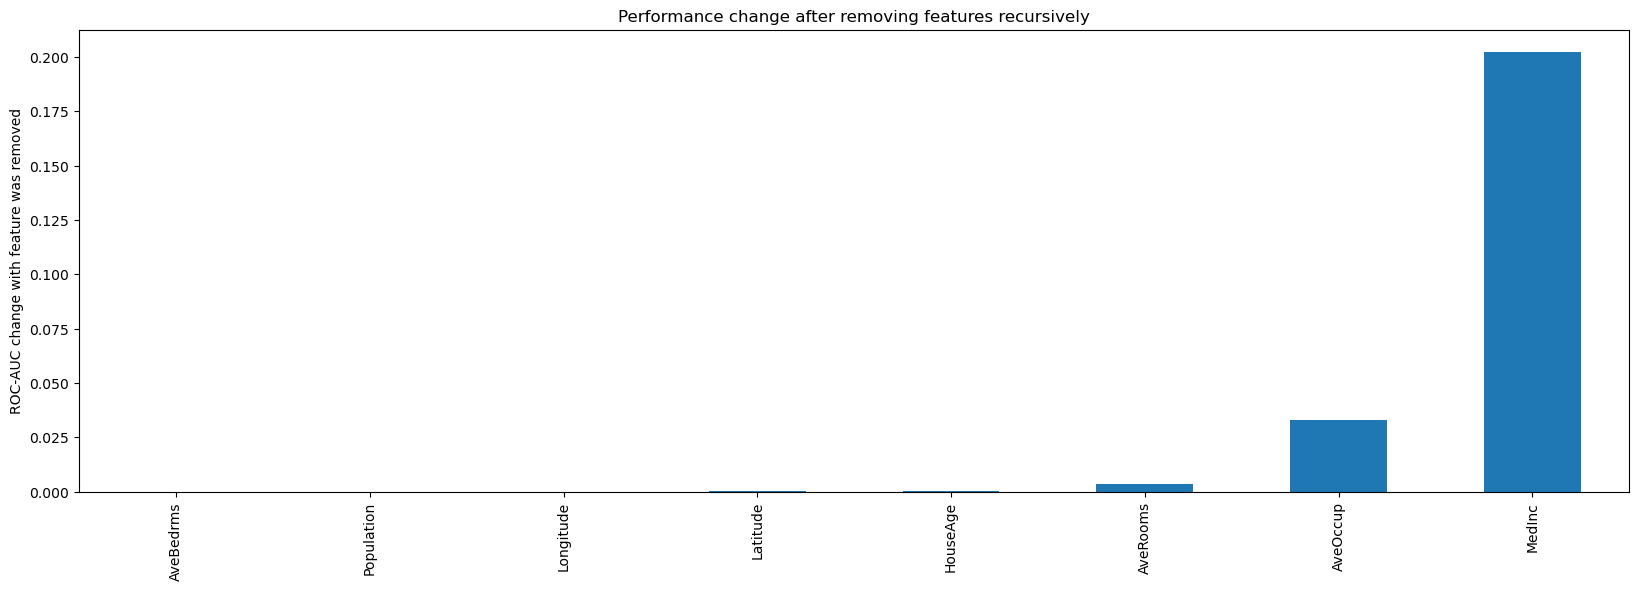

In [40]:
### Plot change in performance

pd.Series(sel.performance_drifts_).plot.bar(figsize = (20, 6))
plt.ylabel("ROC-AUC change with feature was removed")
plt.title("Performance change after removing features recursively")
plt.show()

In [42]:
X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_test_t.head()

,MedInc,AveRooms,AveOccup
14740,4.1518,5.663073,4.180593
10101,5.7796,6.107226,3.020979
20566,4.3487,5.930712,2.910112
2670,2.4511,4.992958,2.746479
15709,5.0049,4.319261,1.712401


In [43]:
sel.features_to_drop_

['HouseAge', 'AveBedrms', 'Population', 'Latitude', 'Longitude']

##### Step by step feature elemination implementation

In [44]:
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
r2_full = r2_score(y_test, y_pred_test)
print(f"R2 all features: {r2_full}")

R2 all features: 0.3564875693230235


In [46]:
features = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending=True)
features.head()

AveBedrms     0.000000
Population    0.000000
Latitude      0.000000
Longitude     0.000000
HouseAge      0.009201
dtype: float64

In [47]:
features = list(features.index)

tol = 0.001

features_to_remove = []

for feature in features:
    model_int = clone(model)
    model_int.fit(X_train.drop(features_to_remove + [feature], axis = 1), y_train)
    y_pred_test = model_int.predict(X_test.drop(features_to_remove + [feature], axis = 1))
    r2_int = r2_score(y_test, y_pred_test)
    
    diff_r2 = r2_full - r2_int
    
    if diff_r2 < tol:
        features_to_remove.append(feature)

print(f"Number of features to remove: {len(features_to_remove)}")

Number of features to remove: 4


In [49]:
features_to_keep = [feature for feature in features if feature not in features_to_remove]
features_to_keep

['HouseAge', 'AveRooms', 'AveOccup', 'MedInc']

### Final model testing

In [50]:
model_final = clone(model)

model_final.fit(X_train[features_to_keep], y_train)
y_pred_test = model_final.predict(X_test[features_to_keep])
roc_final = r2_score(y_test, y_pred_test)
print(f'r2 selected fature = {roc_final}')

r2 selected fature = 0.3564875693230233


### 8.3 Feature shuffling

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.base import clone
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# feature engine
from feature_engine.selection import SelectByShuffling


In [52]:
brest_cancer = load_breast_cancer()
X = pd.DataFrame(brest_cancer.data, columns = brest_cancer.feature_names)
y = brest_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [54]:
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=2909
)

sel = SelectByShuffling(
    estimator=rf,
    scoring = "roc_auc",
    threshold=0,
    cv=3,
    random_state=1
)

sel.fit(X_train, y_train)
sel.initial_model_performance_

0.9822274044237158

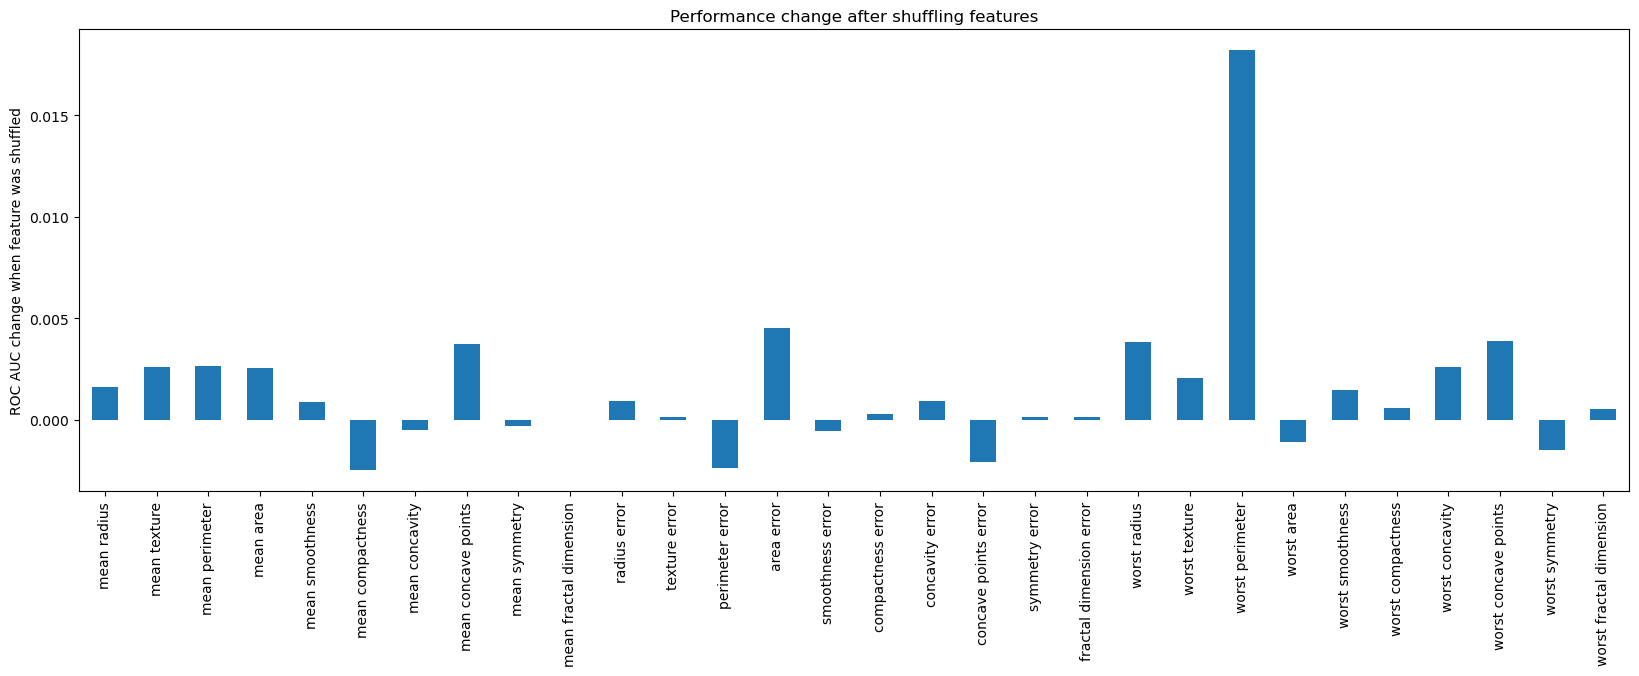

In [55]:
pd.Series(sel.performance_drifts_).plot.bar(figsize = (20,6))
plt.title("Performance change after shuffling features")
plt.ylabel("ROC AUC change when feature was shuffled")
plt.show()

In [56]:
sel.features_to_drop_

['mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst area',
 'worst compactness',
 'worst symmetry',
 'worst fractal dimension']

In [57]:
X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_test_t.head()

,mean radius,mean texture,mean perimeter,mean area,mean concave points,area error,worst radius,worst texture,worst perimeter,worst smoothness,worst concavity,worst concave points
512,13.40,20.52,88.64,556.7,0.08172,33.67,16.41,29.66,113.30,0.15740,0.51060,0.20510
457,13.21,25.25,84.10,537.9,0.02068,17.58,14.35,34.23,91.29,0.12890,0.13900,0.06005
439,14.02,15.66,89.59,606.5,0.02652,19.25,14.91,19.31,96.53,0.10340,0.06260,0.08216
298,14.26,18.17,91.22,633.1,0.01374,20.56,16.22,25.26,105.80,0.09445,0.15650,0.07530
37,13.03,18.42,82.61,523.8,0.02923,14.16,13.30,22.81,84.46,0.09701,0.04833,0.05013


##### Step by step feature shuffling

In [59]:
rf.fit(X_train, y_train)
print("train auc score", roc_auc_score(y_train, (rf.predict_proba(X_train.fillna(0)))[:,1]))
print("test auc score", roc_auc_score(y_test, (rf.predict_proba(X_test.fillna(0)))[:,1]))

train auc score 0.9998822226933315
test auc score 0.9908805031446541


In [61]:
# train roc auc using all features
train_roc = roc_auc_score(y_train, (rf.predict_proba(X_train))[:, 1])

performance_shift = []

for feature in X_train.columns:
    X_train_c = X_train.copy()
    shuffle = X_train_c[feature].sample(frac = 1, random_state = 10)
    shuffle.index = X_train_c.index
    X_train_c[feature] = shuffle
    
    shuff_roc = roc_auc_score(y_train, rf.predict_proba(X_train_c)[:, 1])
    
    drift = train_roc - shuff_roc
    
    performance_shift.append(drift)
    
print(performance_shift)

[0.0, 0.0002826655360045338, -0.00010599957600176957, 7.06663840011057e-05, 2.35554613337019e-05, 1.177773066685095e-05, 0.0002591100746708319, 0.0017313264080277557, 1.177773066685095e-05, 0.0, 5.888865333425475e-05, 1.177773066685095e-05, 0.00020022142133657717, 7.06663840011057e-05, -4.71109226674038e-05, 2.35554613337019e-05, 0.00010599957600165855, 4.71109226674038e-05, 1.177773066685095e-05, 4.71109226674038e-05, 0.00012955503733547147, 0.0004004428426730433, 0.007290415282783402, 1.177773066685095e-05, 0.00012955503733547147, 0.0, 0.0005299978800085148, 0.0004004428426730433, 7.06663840011057e-05, 0.0]


In [63]:
feature_importance = pd.Series(
    performance_shift, index = X_train.columns
).sort_values(ascending=False)

feature_importance.head()

worst perimeter         0.007290
mean concave points     0.001731
worst concavity         0.000530
worst concave points    0.000400
worst texture           0.000400
dtype: float64

In [64]:
feature_importance[feature_importance>0].index

Index(['worst perimeter', 'mean concave points', 'worst concavity',
       'worst concave points', 'worst texture', 'mean texture',
       'mean concavity', 'perimeter error', 'worst radius', 'worst smoothness',
       'concavity error', 'area error', 'mean area', 'worst symmetry',
       'radius error', 'concave points error', 'fractal dimension error',
       'mean smoothness', 'compactness error', 'texture error',
       'mean symmetry', 'mean compactness', 'symmetry error', 'worst area'],
      dtype='object')

In [66]:
# Final model training with selected features
select_features = feature_importance[feature_importance>0].index

rf = clone(rf)
rf.fit(X_train[select_features], y_train)
print("train auc score", roc_auc_score(y_train, (rf.predict_proba(X_train[select_features]))[:,1]))
print("test auc score", roc_auc_score(y_test, (rf.predict_proba(X_test[select_features]))[:,1]))

train auc score 0.9999882222693333
test auc score 0.9959119496855346
